# PastePicture2Wallpaper　

壁紙作成のための線画作成ツールです🎠

<br>

処理手順
1. 深度閾値に従ってMidasを用いた単眼深度推定を行います
2. Canny法による線画抽出を行います(線画化過程でノイズ除去や線を太くするなどの処理を行っています)
3. OSの雰囲気に応じて半透明化した線画を出力します（result.pngという名前で出力されます）

<br>

🆕 : informative_drawingsが有効になりました。（デフォルト：True）

informative_drawingsはAIによって線画抽出を行います。

- median_k_sizeとmodeのオプションは無視されます。

<br>

以下のパラメータで値を弄ってください


<!-- - image_upload_option: 画像をアップロードする方法 -->
  <!-- - `Upload from device`: デバイスからアップロード -->
  <!-- - `URL`: URLからダウンロード -->
  <!-- - `Mount Drive`: Google Driveのマウントを行う -->
<!-- - path_or_url: ダウンロード先のURLかマウント先のデバイスのパスを指定(Upload from devieの場合は無視されます) -->
- mode: 線画処理のモード
  - Anime : アニメ風の輪郭がはっきりとしている画像向け
- OS: 壁紙のOSの種類によって出力される線画の雰囲気が少し変わります
  - Mac風(灰色):パステルカラーの背景に合わせて半透明の灰色線画を出力
  - Mac風(白色):鮮やかな背景に半透明の白線画を出力
  - Windows風: 水色の背景にさらに明るい水色半透明の線画を出力
  - Ubuntu風: 紫-桃色の背景に馴染む桃色半透明の線画を出力
- median_k_size: 細かなノイズを除去します。1の場合、無効化します。
- morph_g_ksize: モロフォジー変換用カーネルサイズ。膨張した画像と収縮した画像の差分をとる処理を行い、物体の輪郭を得ます。1の場合は無効化します。
- depth_threshold: 出力された深度情報をもとに線画化するための閾値



![](https://raw.githubusercontent.com/Ar-Ray-code/PastePicture2Wallpaper/main/images_for_readme/export-variation.png)

> デバイスからのアップロードのみ受け付けています
> 
> 直接URLを指定する場合は4番目のコードセルのURLを変更してコメントアウトを外し、以降のセルを実行（Ctrl+F10） を行ってください

In [150]:
# image_upload_option = 'Upload from device' #@param ["Upload from device", "URL", "Mount Drive"] {allow-input: true}
# path_or_url = "/content/sample.jpg"#@param {type:"string"}

mode = 'Anime' #@param ["Anime"] {allow-input: true}
OS =  'Mac-Gray' #@param ["Ubuntu","Windows","Mac-White","Mac-Gray"] {allow-input: true}
using_informative_drawings = "True" #@param ["True", "False"] {allow-input: true}

# median_ksize=median_ksize, morph_g_ksize=morph_g_ksize

median_ksize = 5 #@param {type:"slider", min:1, max:9, step:2}
morph_g_ksize = 5 #@param {type:"slider", min:1, max:9, step:2}
depth_threshold = 150 #@param {type:"slider", min:0, max:255, step:1}
canny_threshold = 150 #@param {type:"slider", min:0, max:255, step:1}

In [2]:
# Upload from device
from google.colab import files
uploaded = files.upload()

#@markdown ### アップロードを (Choose Files)から行ってください
#@markdown Driveのマウントの場合はこのステップを飛ばして、新しくコードセルを作成して、`/content`に対象ファイルをコピーしてください

# from google.colab import drive
# drive.mount('/content/drive')

Saving urara-toresen.jpg to urara-toresen.jpg


In [ ]:
#@markdown ###URLを指定する場合はこちらを編集し、upload.jpgで保存すること
# !rm sample.jpg
# !wget "https://drive.google.com/uc?export=download&id=1M1eDdinWr-aPT28cyOo01LlMFUnsBbRQ" -O upload.jpg

In [ ]:
!ffmpeg -i *.png upload.jpg
!ffmpeg -i *.jpg upload.jpg

In [ ]:
!pip install tensorflow==2.8.0 tensorflow-hub==0.12.0 onnxruntime

In [6]:
import cv2
import numpy as np

import matplotlib.pyplot as plt
import tensorflow_hub as hub

module = hub.load("https://tfhub.dev/intel/midas/v2_1_small/1", tags=['serve'])
model = module.signatures['serving_default']

In [7]:
import tensorflow as tf

# 画像読み込み
image = cv2.imread('/content/upload.jpg')

# リサイズ
resize_image = cv2.resize(image, (256, 256))

# 正規化
resize_image = cv2.cvtColor(resize_image, cv2.COLOR_BGR2RGB) / 255.0

# 形状変更
resize_image = resize_image.transpose(2, 0, 1)
resize_image = resize_image.reshape(1, 3, 256, 256)

# tensor形式へ変換
tensor = tf.convert_to_tensor(resize_image, dtype=tf.float32)

In [8]:
result = model(tensor)
predict_result = result['default'].numpy()
predict_result = np.squeeze(predict_result)

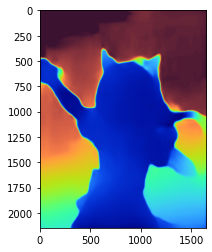

In [9]:
# オリジナル画像のサイズにリサイズ
predict_result = cv2.resize(predict_result, (image.shape[1], image.shape[0]))

# 最大値が255になるよう変換
depth_max = predict_result.max()
data = ((predict_result / depth_max) * 255).astype(np.uint8)

# カラーマップ画像へ変換
color_map = cv2.applyColorMap(data, cv2.COLORMAP_TURBO)

# 表示
plt.imshow(color_map)

線画化

必ず実行

In [139]:
class image_utils:
    def median_filter(self, src, ksize):
        d = int((ksize-1)/2)
        h, w = src.shape[0], src.shape[1]
        dst = src.copy()

        for y in range(d, h - d):
            for x in range(d, w - d):
                dst[y][x] = np.median(src[y-d:y+d+1, x-d:x+d+1])
        return dst

    def export_edges_anime(self, image_raw: np.ndarray, depth_data: np.ndarray, median_ksize: int = 3, morph_g_ksize: int = 3, depth_threshold: int = 150, canny_threshold: int = 150):
        mask = depth_data > depth_threshold
        # maskを二値化
        mask = mask.astype(np.uint8) * 255
        # imageとmaskの合成
        result = cv2.bitwise_and(image_raw, image_raw, mask=mask)

        return self.anime2line(result, median_ksize=median_ksize, morph_g_ksize=morph_g_ksize, threshold=canny_threshold)

    def anime2line(self, image_raw: np.ndarray, median_ksize: int = 3, morph_g_ksize: int = 3, threshold: int = 150):
        edges = cv2.cvtColor(image_raw, cv2.COLOR_BGR2GRAY)

        # Canny輪郭検出
        edges = cv2.Canny(edges, threshold, threshold)

        # MorphologyEx
        if morph_g_ksize == 1:
            pass
        else:
            kernel_giant = np.ones((morph_g_ksize, morph_g_ksize), np.uint8)
            edges = cv2.morphologyEx(edges, cv2.MORPH_GRADIENT, kernel_giant)

        # 色の反転
        edges = cv2.bitwise_not(edges)
        edges = edges.astype(np.uint8) * 255 * 255
        edges = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)

        # メディアンフィルタ
        if median_ksize == 1:
            pass
        else:
            edges = self.median_filter(edges, ksize=median_ksize)

        ret, output = cv2.threshold(edges, 200, 255, cv2.THRESH_BINARY)
        return edges

    # 白を透明にして色付きを半透明の白にする
    def white2transparent(self, input_image: np.ndarray, os_type: str = 'Ubuntu'):
        if os_type == 'Ubuntu':
            image_png = cv2.cvtColor(input_image, cv2.COLOR_RGB2RGBA)
            for i in range(image_png.shape[0]):
                for j in range(image_png.shape[1]):
                    if image_png[i][j][0] == 255 and image_png[i][j][1] == 255 and image_png[i][j][2] == 255:
                        image_png[i][j][3] = 0
                    else:
                        image_png[i][j][0] = 255
                        image_png[i][j][1] = 200
                        image_png[i][j][2] = 255
                        image_png[i][j][3] = 200
        elif os_type == 'Windows':
            image_png = cv2.cvtColor(input_image, cv2.COLOR_RGB2RGBA)
            for i in range(image_png.shape[0]):
                for j in range(image_png.shape[1]):
                    if image_png[i][j][0] == 255 and image_png[i][j][1] == 255 and image_png[i][j][2] == 255:
                        image_png[i][j][3] = 0
                    else:
                        image_png[i][j][0] = 200
                        image_png[i][j][1] = 255
                        image_png[i][j][2] = 255
                        image_png[i][j][3] = 200
        elif os_type == 'Mac-White':
            image_png = cv2.cvtColor(input_image, cv2.COLOR_RGB2RGBA)
            for i in range(image_png.shape[0]):
                for j in range(image_png.shape[1]):
                    if image_png[i][j][0] == 255 and image_png[i][j][1] == 255 and image_png[i][j][2] == 255:
                        image_png[i][j][3] = 0
                    else:
                        image_png[i][j][0] = 200
                        image_png[i][j][1] = 200
                        image_png[i][j][2] = 200
                        image_png[i][j][3] = 200
        elif os_type == 'Mac-Gray':
            image_png = cv2.cvtColor(input_image, cv2.COLOR_RGB2RGBA)
            for i in range(image_png.shape[0]):
                for j in range(image_png.shape[1]):
                    if image_png[i][j][0] == 255 and image_png[i][j][1] == 255 and image_png[i][j][2] == 255:
                        image_png[i][j][3] = 0
                    else:
                        image_png[i][j][0] = 70
                        image_png[i][j][1] = 70
                        image_png[i][j][2] = 70
                        image_png[i][j][3] = 200
        else:
            print("cannot detect wallpaper OS")
        return image_png

線画化２

## Informative-drawings
ファイルのダウンロード作業。スキップするほどでもないですが、ダウンロードを行わない場合はこの工程をスキップしてください。

In [10]:
!git clone https://github.com/carolineec/informative-drawings
%cd informative-drawings

!mkdir checkpoints
!gdown 'https://drive.google.com/uc?id=11l5u5sb1PO5Z5YA3IoEHauVPm0k407C1'
!unzip model.zip -d checkpoints

Cloning into 'informative-drawings'...
remote: Enumerating objects: 101, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 101 (delta 21), reused 14 (delta 13), pack-reused 73
Receiving objects: 100% (101/101), 3.86 MiB | 42.01 MiB/s, done.
Resolving deltas: 100% (39/39), done.
/content/informative-drawings


In [154]:
import os

import torch
from model import Generator

import onnxruntime
import cv2 as cv
import numpy as np

input_size = 512
# ドットアクセス用の辞書クラス
class DictDotNotation(dict): 
    def __init__(self, *args, **kwargs): 
        super().__init__(*args, **kwargs) 
        self.__dict__ = self
# 疑似的なコマンドライン引数生成

class InformativeDrawings:
    def create_options(self) -> DictDotNotation:
        opt = DictDotNotation()

        opt.name = 'model/anime_style'
        opt.dataroot = 'examples/test'
        opt.checkpoints_dir = 'checkpoints'
        opt.results_dir = 'results'
        opt.geom_name = 'feats2Geom'
        opt.batchSize = 1
        opt.depthroot = ''
        opt.input_nc = 3
        opt.output_nc = 1
        opt.geom_nc = 3
        opt.every_feat = 1
        opt.num_classes = 55
        opt.midas = 0
        opt.ngf = 64
        opt.n_blocks = 3
        opt.size = input_size
        opt.cuda = True
        opt.n_cpu = 8
        opt.which_epoch = 'latest'
        opt.aspect_ratio = 1.0
        opt.mode = 'test'
        opt.load_size = input_size
        opt.crop_size = input_size
        opt.max_dataset_size = float("inf")
        opt.preprocess = 'resize_and_crop'
        opt.no_flip = False
        opt.norm = 'instance'
        opt.predict_depth = 0
        opt.save_input = 0
        opt.reconstruct = 0
        opt.how_many = 100
        return opt

    def convert_to_onnx(self, net, file_name='output.onnx', input_shape=(512, 512), device='cpu'):
        input = torch.randn(1, 3, input_shape[0], input_shape[1]).to(device)

        input_layer_names = ['input_image']
        output_layer_names = ['output_image']

        torch.onnx.export(
            net, 
            input, 
            file_name, 
            verbose=True,
            opset_version=11,
            input_names=input_layer_names,
            output_names=output_layer_names,
        )
    
    def export_edges_anime(self, image_raw: np.ndarray, depth_data: np.ndarray, morph_g_ksize: int = 3, depth_threshold: int = 150) -> np.ndarray:
        mask = depth_data > depth_threshold
        # maskを二値化
        mask = mask.astype(np.uint8) * 255
        # imageとmaskの合成
        result = cv2.bitwise_and(image_raw, image_raw, mask=mask)

        return self.generate(result, morph_g_ksize)

    def generate(self, input_image, morph_g_ksize) -> np.ndarray:

        # ネットワーク生成
        opt = self.create_options()
        net_G = Generator(opt.input_nc, opt.output_nc, opt.n_blocks)

        # 重みをロード
        net_G.load_state_dict(torch.load(os.path.join(opt.checkpoints_dir, opt.name, 'netG_A_%s.pth' % opt.which_epoch)))
        device = 'cpu'
        net_G.eval().to(device)

        print('Loaded：', os.path.join(opt.checkpoints_dir, opt.name, 'netG_A_%s.pth' % opt.which_epoch))

        self.convert_to_onnx(net_G, 'anime_style_512x512.onnx', (input_size, input_size), device)

        # ONNXモデルロード
        onnx_session = onnxruntime.InferenceSession(
            'anime_style_512x512.onnx',
            providers=['CUDAExecutionProvider', 'CPUExecutionProvider'],
        )

        input_name = onnx_session.get_inputs()[0].name
        output_name = onnx_session.get_outputs()[0].name


        # 前処理 (input is image)
        image_data = cv.resize(input_image, dsize=(input_size, input_size))
        x = cv.cvtColor(image_data, cv.COLOR_BGR2RGB)

        x = np.array(x, dtype=np.float32)
        x = x.transpose(2, 0, 1)
        x = x.reshape(-1, 3, input_size, input_size)

        # 推論
        onnx_result = onnx_session.run([output_name], {input_name: x})

        # 後処理
        onnx_result = np.array(onnx_result).squeeze()
        onnx_result = onnx_result * 255
        onnx_result = onnx_result.astype(np.uint8)

        
        ret, output = cv2.threshold(onnx_result, 200, 255, cv2.THRESH_BINARY)

        # kernel_giant = np.ones((morph_g_ksize, morph_g_ksize), np.uint8)
        # output = cv2.morphologyEx(output, cv2.MORPH_GRADIENT, kernel_giant)


        output = cv2.cvtColor(output, cv2.COLOR_GRAY2BGR)
        output = cv2.resize(output, (image.shape[1],image.shape[0]))
        return output
    


In [155]:
image_utils_class = image_utils()

if using_informative_drawings == "True":
    print("using informative drawings...")
    id_class = InformativeDrawings()
    image_line = id_class.export_edges_anime(image, depth_data=data, morph_g_ksize=morph_g_ksize, depth_threshold=depth_threshold)
else:
    print("using canny...")
    image_line = image_utils_class.export_edges_anime(image_raw=image, depth_data=data, median_ksize=median_ksize, morph_g_ksize=morph_g_ksize, depth_threshold=depth_threshold, canny_threshold=canny_threshold)
#@markdown ## export_edges_anime関数
#@markdown ### 引数一覧
#@markdown - image_raw: 画像（読み込み時のまま）
#@markdown - depth_data: 深度データ(2次元のndarray・0~255)
#@markdown - threshold: 深度の閾値（0~255・int型）
#@markdown
#@markdown ### 出力一覧
#@markdown - image: マスク済み画像
#@markdown
#@markdown ### 分岐
#@markdown - informative drawings をTrueに設定するとAI線画に、FalseにするとCanny線画になります。

using informative drawings...
Loaded： checkpoints/model/anime_style/netG_A_latest.pth


In [157]:
image_png = image_utils_class.white2transparent(image_line, OS)

#@markdown ## white2transparent関数
#@markdown 白領域を透明化する関数（色付きは半透明の白になります）

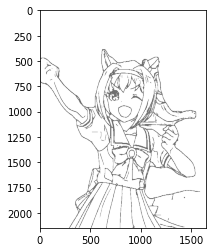

In [158]:
plt.imshow(image_png)

In [159]:
plt.imsave("/content/result.png",image_png)
from google.colab import files
files.download('/content/result.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Export depth
#@markdown convert.pyで深度情報を確認する時はこのセルを実行して`depth_result.png`をダウンロードします。

# # v----この行以下をコメントアウト--------v
# export_png = np.zeros((data.shape[0], data.shape[1], 3))
# export_png[:,:,0] = data/255
# export_png[:,:,1] = data/255
# export_png[:,:,2] = data/255

# plt.imsave("/content/depth_result.png",export_png)
# files.download('depth_result.png')